# Fuzzed vs Vanilla flight path analysis

# Fuzzed vs Vanilla flight path analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fastdtw import fastdtw

### We generate the csv files via the ulog2csv utility and target the vehicle_local_position message

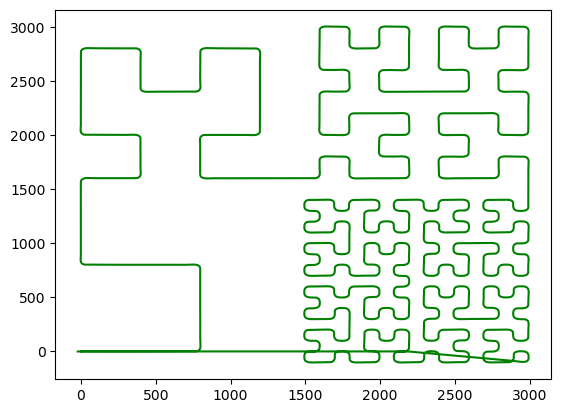

In [2]:
vanilla_pos_df = pd.read_csv("standard_autopilot/vanilla/vl0_vehicle_local_position_0.csv")
plt.plot(vanilla_pos_df["y"], vanilla_pos_df["x"], "g")
plt.show()

# VL1, VL2 and FZL1 have the correct flight path, all others have the straight landing pattern, but results drawn shouldn't differ greatly

<function matplotlib.pyplot.show(close=None, block=None)>

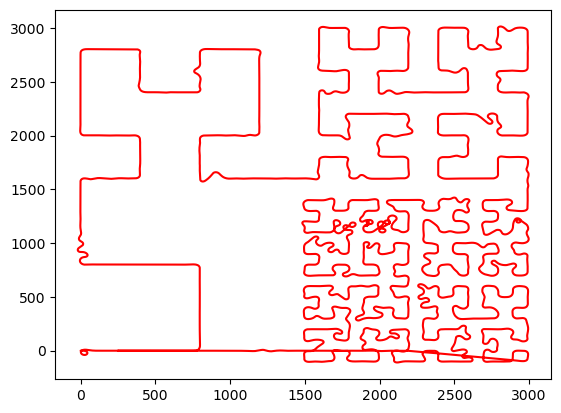

In [47]:
fuzzed_pos_df = pd.read_csv("standard_autopilot/fuzzed/fzl7_vehicle_local_position_0.csv")
plt.plot(fuzzed_pos_df["y"], fuzzed_pos_df["x"], "r") # fzl1 corect, others use straight flight path
plt.show()

In [3]:
def df2path(df):
    return np.transpose(np.stack((df["x"], df["y"])))

def log2path_standard(isVanilla, index):
    """Takes vanilla or fuzzed index and returns a 2d array of x,y coordinates"""
    prefix = "standard_autopilot/vanilla/vl" if isVanilla else "standard_autopilot/fuzzed/fzl"
    pdf = pd.read_csv(prefix + str(index) + "_vehicle_local_position_0.csv")
    return df2path(pdf)

def log2path_rcac(isVanilla, index):
    """Takes vanilla or fuzzed index and returns a 2d array of x,y coordinates"""
    prefix = "rcac_autopilot/vanilla/vl" if isVanilla else "rcac_autopilot/fuzzed/fzl"
    pdf = pd.read_csv(prefix + str(index) + "_vehicle_local_position_0.csv")
    return df2path(pdf)

In [10]:
vanilla_path  = log2path_standard(True, 1)
fuzzed_path  = log2path_standard(False, 1)
vf_distance, vf_path = fastdtw(vanilla_path, fuzzed_path)
print(vf_distance)

351001.09118142916


### Now we can construct a similarity matrix with the dynamic-time-warping as a distance metric
The matrix will be upper-triangular with 0s along the diagnonal as in the example below

In [15]:
mat = np.zeros((5,5))
for i in range(5):
    for j in range(1, 5-i):
        mat[i, i+j] = 1
print(mat)

[[0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]]


In [55]:
vanilla_simmat = np.zeros((5,5))
for i in range(5):
    for j in range(1, 5-i):

        if i == 2 or j == 2 or i == 1 or j == 1:# bad trials, wrong flightpath
            continue

        p1 = log2path_standard(True, i)
        p2 = log2path_standard(True, j)
        wdist, dtwpath = fastdtw(p1, p2) 
        vanilla_simmat[i, i+j] = wdist
print(vanilla_simmat)

[[    0.             0.             0.         21532.62338518
  20480.52512101]
 [    0.             0.             0.             0.
      0.        ]
 [    0.             0.             0.             0.
      0.        ]
 [    0.             0.             0.             0.
      0.        ]
 [    0.             0.             0.             0.
      0.        ]]


In [56]:
from statistics import *

alldists = np.array([i for i in filter(lambda x: x != 0, vanilla_simmat.flat)])
m = mean(alldists)
print("vanilla simmat mean:", m, "stdev:", stdev(alldists))
print("normalized vanilla simmat mean:", mean(alldists/m), "stdev:", stdev(alldists/m))

vanilla simmat mean: 21006.574253098388 stdev: 743.9458170711135
normalized vanilla simmat mean: 1.0 stdev: 0.03541490431079609


### fuzz crash rate 2/10

In [4]:
NUM_TRIALS = 8
fuzzed_simmat = np.zeros((NUM_TRIALS,NUM_TRIALS))
for i in range(NUM_TRIALS):
    for j in range(1, NUM_TRIALS-i):
        if i == 1 or j==1: # bad trial
            continue

        p1 = log2path_standard(False, i)
        p2 = log2path_standard(False, j)
        wdist, dtwpath = fastdtw(p1, p2) 
        fuzzed_simmat[i, i+j] = wdist
print(fuzzed_simmat)

[[     0.              0.         475253.58490408 454590.04131215
  536050.43823219 446122.44264294 432097.10466223 471589.54262584]
 [     0.              0.              0.              0.
       0.              0.              0.              0.        ]
 [     0.              0.              0.              0.
       0.         544286.88561479 572063.44377332 486542.90152473]
 [     0.              0.              0.              0.
       0.         544286.88561479      0.         388050.61060918]
 [     0.              0.              0.              0.
       0.              0.         572063.44377332 388050.61060918]
 [     0.              0.              0.              0.
       0.              0.              0.         486542.90152473]
 [     0.              0.              0.              0.
       0.              0.              0.              0.        ]
 [     0.              0.              0.              0.
       0.              0.              0.              0.  

In [13]:
from statistics import *

alldists = np.array([i for i in filter(lambda x: x != 0, fuzzed_simmat.flat)])
m = mean(alldists)
print("fuzzed simmat mean:", m, "stdev:", stdev(alldists))
print("normalized fuzzed simmat mean:", mean(alldists/m), "stdev:", stdev(alldists/m))

fuzzed simmat mean: 487125.6710659544 stdev: 60678.0493083545
normalized fuzzed simmat mean: 1.0 stdev: 0.12456344001656812


In [58]:
vanilla_dists = []
vanilla_path = log2path_standard(True, 0)

for i in range(NUM_TRIALS):
    if i == 1:  # bad trial
        continue

    fuzzed_path =  log2path_standard(False, i)
    vf_distance, vf_path = fastdtw(vanilla_path, fuzzed_path)
    vanilla_dists.append(vf_distance)
print(vanilla_dists)

[298646.1097023299, 306377.02746671165, 378839.10591440403, 422882.8457175708, 316093.8444374265, 290295.71768941416, 323559.2478513834]


In [59]:
print("mean distance between fuzzed and vanilla trials:", mean(vanilla_dists), "stdev:", stdev(vanilla_dists))
print("normalized mean:", 1.0, "stdev:", stdev(vanilla_dists/mean(vanilla_dists)))

mean: 333813.41411132005 stdev: 48756.35370133391
normalized mean: 1.0 stdev: 0.14605870117932007
